# Landcover in commuting zones

Check overlap of NOAA landcover data with meta commuting zones for the USA

In [1]:
import geopandas as gpd
from fiona.errors import DriverError
import pandas as pd
from rasterstats import zonal_stats
import rasterio as rs
import os
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import seaborn as sns
from shapely import wkt
import numpy as np


In [2]:
def fill_zip(zip_incomplete):
        return str(zip_incomplete).zfill(5)

In [3]:
# files always needed
DATA_LANDCOVER_DIR = os.path.expanduser(f"~/Desktop/largefiles/gap_landfire_nationalterrestrialecosystems2011")
DATA_LANDCOVER_RASTER = f"{DATA_LANDCOVER_DIR}/gap_landfire_nationalterrestrialecosystems2011.tif"
DATA_LANDCOVER_META = f"{DATA_LANDCOVER_DIR}/gaplf2011_conus_attributes_16dec2016.xlsx"

DATA_SOCIALCAPITAL= os.path.expanduser(f"~/Desktop/largefiles/meta_social_capital_zip.csv")

# define level from [fbcz, zip]
level = "zip"
# which coast buffer was used if any
coast_buffer = None #km

if coast_buffer is None:
    area = "usa"

    if level == "fbcz":
        DATA_AREAS = os.path.expanduser(f"~/Library/CloudStorage/GoogleDrive-theokrueger.marbio@gmail.com/My Drive/23_24_WS/Internship_DTU/meta/commuting/commuting-zones_usa/commuting-zones_usa.shp")
        DATA_ZIP_TO_CZ = os.path.expanduser(f"~/Desktop/largefiles/zip_to_cz_us.csv")
        DATA_SOCIALCAPITAL_CZ = os.path.expanduser(f"~/Desktop/largefiles/meta_social_capital_zip_agg.csv")
    
    elif level == "zip":
        DATA_AREAS = os.path.expanduser(f"~/Desktop/largefiles/tl_2023_us_zcta520/tl_2023_us_zcta520.shp")
        DATA_ZIP_INFO = os.path.expanduser(f"~/Desktop/largefiles/simplemaps_uszips_basicv1.83/uszips.csv")

else:
    if level == "fbcz":
        area = f"uswestcoast_{coast_buffer}km"
        DATA_AREAS = os.path.expanduser(f"~/Library/CloudStorage/GoogleDrive-theokrueger.marbio@gmail.com/My Drive/23_24_WS/Internship_DTU/meta/commuting/commuting-zones_uswestcoast_{coast_buffer}km/commuting-zones_uswestcoast_{coast_buffer}km.shp")



In [4]:
with rs.open(DATA_LANDCOVER_RASTER) as image:
    print(f"Number of bands: {image.count}")
    raster_crs = image.crs
    print(f"CRS: {raster_crs}")

Number of bands: 1
CRS: EPSG:5070


In [5]:
raster_meta = pd.read_excel(DATA_LANDCOVER_META)
# raster_meta.head()

In [6]:
# which level of detail? check metadata
landcover_detail = "Custom_groups"

if level == "fbcz": 
    path_base = f"{os.getcwd()}/../Output/USGSlandcover_{level}_{landcover_detail}"
elif level == "zip": 
    path_main = os.path.expanduser(f'~/Desktop/largefiles/Output/')
    if not os.path.isdir(path_main): os.mkdir(path_main)
    path_base = f"{path_main}/USGSlandcover_{level}_{landcover_detail}"

if not os.path.isdir(path_base): os.mkdir(path_base)

path_data = f"{path_base}/data"
if not os.path.isdir(path_data): os.mkdir(path_data)
file_out_base_data = f"{path_data}/{level}_USGSlandcover_{area}"

path_figures = f"{path_base}/figures"
if not os.path.isdir(path_figures): os.mkdir(path_figures)
file_out_base_data_figures = f"{path_figures}/USGSlandcover_{level}_{area}_Detail{landcover_detail}_figure"


In [7]:
file_landcovers = f"{os.getcwd()}/../USGSlandcover_landcoverCategories.csv"

if landcover_detail == "Custom_groups":
    try:
        raster_meta_custom = pd.read_csv(file_landcovers)[['ECOLSYS_LU', 'Custom_groups']]
        raster_meta = raster_meta.merge(raster_meta_custom, on="ECOLSYS_LU")
        print("Custom groupings found and merged")
    except FileNotFoundError:
        raster_meta_landcovers = raster_meta.iloc[:,[1,6,8,10,12,14,16,18]]
        raster_meta_landcovers.to_csv(f"{os.path.splitext(file_landcovers)[0]}_raw.csv", index=False)
        # change groups and run again
    
landcover_legend_lowest = dict(zip(raster_meta['Value'], raster_meta['ECOLSYS_LU']))
landcover_legend_lowest.update({0: "Background"})

landcover_legend_rename = dict(zip(raster_meta['ECOLSYS_LU'], raster_meta[landcover_detail]))
landcover_legend_rename.update({0: "Background"})

landcover_columns = list(set([col for col in landcover_legend_rename.values() if str(col) != 'nan']))
print(f"Landcovers: {landcover_columns}")


Custom groupings found and merged
Landcovers: ['Swamp', 'Aquatic Vegetation', 'Cool Temperate Forest & Woodland', 'Rock', 'Warm Desert & Semi-Desert Woodland, Scrub & Grassland', 'Shrubland', 'Cool Semi-Desert Scrub & Grassland', 'Tropical Forest & Woodland', 'Mudflat', 'Agricultural & Developed Vegetation', 'Flatwoods', 'Tundra', 'Barren', 'Background', 'Recently Disturbed', 'Floodplain Forest', 'Wetland', 'Warm Temperate Forest & Woodland', 'Open Water', 'Boreal Forest & Woodland', 'Bog & Fen', 'Canyon', 'Developed', 'Marsh', 'Beach', 'Grassland', 'Cliff']


In [37]:
file_base_shapes = f"{path_data}/gdf_{level}_base_shapes"
file_base = f"{path_data}/df_{level}_base.csv"

try:
    gdf_shapes = gpd.read_file(file_base_shapes)

except DriverError:

    gdf_shapes = gpd.read_file(DATA_AREAS).to_crs(raster_crs)

    if level == "zip":
        gdf_shapes = gdf_shapes[["ZCTA5CE20", "geometry"]].rename(columns={"ZCTA5CE20":"ZIP_CODE"})

        # cut to US mainland
        print("Cutting to mainland USA")
        df_zip_info = pd.read_csv(DATA_ZIP_INFO)

        usmainland_states = {
            #'AK': 'Alaska',
            'AL': 'Alabama',
            'AR': 'Arkansas',
            'AZ': 'Arizona',
            'CA': 'California',
            'CO': 'Colorado',
            'CT': 'Connecticut',
            'DC': 'District of Columbia',
            'DE': 'Delaware',
            'FL': 'Florida',
            'GA': 'Georgia',
            #'HI': 'Hawaii',
            'IA': 'Iowa',
            'ID': 'Idaho',
            'IL': 'Illinois',
            'IN': 'Indiana',
            'KS': 'Kansas',
            'KY': 'Kentucky',
            'LA': 'Louisiana',
            'MA': 'Massachusetts',
            'MD': 'Maryland',
            'ME': 'Maine',
            'MI': 'Michigan',
            'MN': 'Minnesota',
            'MO': 'Missouri',
            'MS': 'Mississippi',
            'MT': 'Montana',
            'NC': 'North Carolina',
            'ND': 'North Dakota',
            'NE': 'Nebraska',
            'NH': 'New Hampshire',
            'NJ': 'New Jersey',
            'NM': 'New Mexico',
            'NV': 'Nevada',
            'NY': 'New York',
            'OH': 'Ohio',
            'OK': 'Oklahoma',
            'OR': 'Oregon',
            'PA': 'Pennsylvania',
            'RI': 'Rhode Island',
            'SC': 'South Carolina',
            'SD': 'South Dakota',
            'TN': 'Tennessee',
            'TX': 'Texas',
            'UT': 'Utah',
            'VA': 'Virginia',
            'VT': 'Vermont',
            'WA': 'Washington',
            'WI': 'Wisconsin',
            'WV': 'West Virginia',
            'WY': 'Wyoming'
        }

        usmainland_zips = \
            df_zip_info.loc[(df_zip_info['state_id'].isin(usmainland_states.keys())) & (df_zip_info['zcta'] == True)]['zip'].to_list() + \
            df_zip_info.loc[(df_zip_info['state_id'].isin(usmainland_states.keys())) & (df_zip_info['zcta'] != True)]['parent_zcta'].to_list() 
        usmainland_zips = list(map(fill_zip, usmainland_zips))

        gdf_shapes = gdf_shapes.loc[gdf_shapes['ZIP_CODE'].isin(usmainland_zips)].reset_index(drop=True)
        
        n_shapes_original = len(gdf_shapes.index)

        # fill holes without zips
        print("Adding shapes in holes")
        zip_shapes_combined = gdf_shapes.geometry.unary_union
        zip_shapes_diff = zip_shapes_combined\
            .envelope\
            .difference(zip_shapes_combined)
        gdf_diff = gpd.GeoDataFrame(geometry=[zip_shapes_diff]).explode().reset_index(drop=True)
        gdf_diff["ZIP_CODE"] = "NO_ZIP_" + (gdf_diff.index + 1).astype(str)
        
        gdf_shapes = pd.concat([gdf_shapes, gdf_diff], ignore_index=True)

        print("Excluding some not useful shapes")
        # first two shapes of NO_ZIP are the sea / Canada, exclude here
        # two shapes are not covered by the rest of the data, exclude here
        zips_excluded = gdf_shapes.loc[gdf_shapes.geometry.area.isin(gdf_shapes.geometry.area.nlargest(2))]['ZIP_CODE'].to_list()
        # zips_excluded = ['NO_ZIP_1', 'NO_ZIP_2', 'NO_ZIP_720', 'NO_ZIP_721']
        gdf_shapes = gdf_shapes[~gdf_shapes['ZIP_CODE'].isin(zips_excluded)]

        gdf_shapes = gdf_shapes.reset_index(drop=True)

        print(f"Total number of shapes: {len(gdf_shapes.index)}")
        print(f"Number of shapes in mainland US: {n_shapes_original}")
        print(f"Number of shapes added: {len(gdf_shapes.index) - n_shapes_original}")

        # save start for adding data later
        df_base = pd.DataFrame(gdf_shapes[['ZIP_CODE']])
        if not os.path.isfile(file_base): df_base.to_csv(file_base, index=False)

        # save base shapefile
        if not os.path.isfile(file_base_shapes): gdf_shapes.to_file(file_base_shapes, index=False)


gdf_shapes.crs

<Projected CRS: EPSG:5070>
Name: NAD83 / Conus Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: Conus Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [8]:
if level == "fbcz":
    level_index = "fbcz_id"
elif level == "zip":
    level_index = "ZIP_CODE"

## Filenames

In [9]:
file_out_base_data_detail = f"{file_out_base_data}_Detail{landcover_detail}"

file_countsonly = f"{file_out_base_data_detail}_countsonly.csv"
file_cellcounts = f"{file_out_base_data_detail}_cellcounts.csv"
file_simplepercentage = f"{file_out_base_data_detail}_percentagecells.csv"
file_areanorm = f"{file_out_base_data_detail}_areanorm.csv"
file_maxcover = f"{file_out_base_data_detail}_maxcover.csv"
file_wilderness = f"{file_out_base_data_detail}_wilderness.csv"
file_diversity = f"{file_out_base_data_detail}_cellcounts_diversity.csv"
file_socialCapital = f"{file_out_base_data_detail}_socialCapital.csv"
file_randomForest_prep = f"{file_out_base_data_detail}_ForRandomForest.csv"
file_randomForest_res = f"{file_out_base_data_detail}_RandFor.csv"

## Overlaying

In [71]:
try: 
    df_shapes_landcover_counts = pd.read_csv(file_cellcounts, dtype={"ZIP_CODE": str})
    df_shapes_landcover_simplepercentage = pd.read_csv(file_simplepercentage, dtype={"ZIP_CODE": str})
    df_shapes_landcover_areanorm = pd.read_csv(file_areanorm, dtype={"ZIP_CODE": str})
    df_base = pd.read_csv(file_base, dtype={"ZIP_CODE": str})
    print("Existing data files found.")

except FileNotFoundError:
    print("Data files not present. Computing overlay...")
    
    stats = pd.DataFrame(
        zonal_stats(
            vectors=gdf_shapes['geometry'], 
            raster=DATA_LANDCOVER_RASTER, 
            categorical=True, 
            category_map=landcover_legend_lowest,
            stats='count'
        )
    )
    print("Finished. Renaming columns to selected detail...")

    stats.to_csv(file_countsonly, index=True)
    
    # renaming columns based on the chosen detail level and combining smaller groups
    stats_rename = stats.rename(columns=landcover_legend_rename)
    stats_rename = stats_rename.T.groupby(stats_rename.columns).sum().T
    
    # add counts to the shapes file and save output
    print(f"Indices of df_base and stats are the same: {all(df_base.index == stats_rename.index)}")
    df_shapes_landcover_counts = df_base.merge(stats_rename, left_index=True, right_index=True, how="left")

    df_shapes_landcover_counts.to_csv(file_cellcounts, index=False)


Existing data files found.


In [12]:
df_n_landcovers = df_shapes_landcover_counts\
    .set_index("ZIP_CODE")\
    .drop(columns=["count"])\
    .astype(bool).sum(axis=1)\
    .reset_index()\
    .rename(columns={0:"n_landcovers"})

In [13]:
df_shapes_landcover_counts.loc[\
    (df_shapes_landcover_counts['count'].isnull()) | \
    (df_shapes_landcover_counts['count'] == 0)
]

Empty DataFrame
Columns: [ZIP_CODE, Agricultural & Developed Vegetation, Aquatic Vegetation, Background, Barren, Beach, Bog & Fen, Boreal Forest & Woodland, Canyon, Cliff, Cool Semi-Desert Scrub & Grassland, Cool Temperate Forest & Woodland, Developed, Flatwoods, Floodplain Forest, Grassland, Marsh, Mudflat, Open Water, Recently Disturbed, Rock, Shrubland, Swamp, Tropical Forest & Woodland, Tundra, Warm Desert & Semi-Desert Woodland, Scrub & Grassland, Warm Temperate Forest & Woodland, Wetland, count]
Index: []

[0 rows x 29 columns]

## Normalization

In [14]:
# finding zones with mostly empty background
high_background_zones = stats_rename.copy(deep=True)
high_background_zones['percent_background'] = stats_rename['Background']/stats_rename['count']
high_background_zones = high_background_zones.loc[high_background_zones['percent_background'] >= 0.2]
high_background_zones['percent_background']

Series([], Name: percent_background, dtype: float64)

In [15]:
# drop high background zones
high_background_zones = high_background_zones.index
stats_rename_filter = stats_rename.drop(index=high_background_zones)

# drop count
stats_rename_filter = stats_rename_filter.drop(['count'], axis=1)

### Basic percentage

In [16]:
stats_rename_filter_forperc = stats_rename_filter.drop(['Background'], axis=1)

stats_rename_simplepercentage = stats_rename_filter_forperc.div(stats_rename_filter_forperc.sum(axis=1), axis=0)
stats_rename_simplepercentage.head()

Agricultural & Developed Vegetation  Aquatic Vegetation  Barren  Beach  \
0                             0.773883                 0.0     0.0    0.0   
1                             0.000000                 0.0     0.0    0.0   
2                             0.000000                 0.0     0.0    0.0   
3                             0.161290                 0.0     0.0    0.0   
4                             0.294118                 0.0     0.0    0.0   

   Bog & Fen  Boreal Forest & Woodland  Canyon  Cliff  \
0        0.0                       0.0     0.0    0.0   
1        0.0                       0.0     0.0    0.0   
2        0.0                       0.0     0.0    0.0   
3        0.0                       0.0     0.0    0.0   
4        0.0                       0.0     0.0    0.0   

   Cool Semi-Desert Scrub & Grassland  Cool Temperate Forest & Woodland  ...  \
0                                 0.0                          0.088519  ...   
1                                 0.0                          0.000000  ...   
2                                 0.0                          0.396825  ...   
3                                 0.0                          0.041056  ...   
4                                 0.0                          0.000000  ...   

   Open Water  Recently Disturbed  Rock  Shrubland     Swamp  \
0         0.0                 0.0   0.0        0.0  0.000000   
1         0.0                 0.0   0.0        0.0  0.000000   
2         0.0                 0.0   0.0        0.0  0.000000   
3         0.0                 0.0   0.0        0.0  0.008798   
4         0.0                 0.0   0.0        0.0  0.000000   

   Tropical Forest & Woodland  Tundra  \
0                         0.0     0.0   
1                         0.0     0.0   
2                         0.0     0.0   
3                         0.0     0.0   
4                         0.0     0.0   

   Warm Desert & Semi-Desert Woodland, Scrub & Grassland  \
0                                                0.0       
1                                                0.0       
2                                                0.0       
3                                                0.0       
4                                                0.0       

   Warm Temperate Forest & Woodland  Wetland  
0                               0.0      0.0  
1                               0.0      0.0  
2                               0.0      0.0  
3                               0.0      0.0  
4                               0.0      0.0  

[5 rows x 26 columns]

In [17]:
# any row that does not sum up to 100%?
stats_rename_simplepercentage.loc[round(stats_rename_simplepercentage.sum(axis=1), 8) != 1]

Empty DataFrame
Columns: [Agricultural & Developed Vegetation, Aquatic Vegetation, Barren, Beach, Bog & Fen, Boreal Forest & Woodland, Canyon, Cliff, Cool Semi-Desert Scrub & Grassland, Cool Temperate Forest & Woodland, Developed, Flatwoods, Floodplain Forest, Grassland, Marsh, Mudflat, Open Water, Recently Disturbed, Rock, Shrubland, Swamp, Tropical Forest & Woodland, Tundra, Warm Desert & Semi-Desert Woodland, Scrub & Grassland, Warm Temperate Forest & Woodland, Wetland]
Index: []

[0 rows x 26 columns]

In [18]:
df_shapes_landcover_simplepercentage = pd.merge(left=df_base, right=stats_rename_simplepercentage, left_index=True, right_index=True)

df_shapes_landcover_simplepercentage.to_csv(file_simplepercentage, index=False)

### Normalized by area

In [19]:
stats_rename_sqkm = (stats_rename_filter * 900) / 1e6

if level == "zip":
    gdf_shapes['area'] = gdf_shapes.geometry.area / 1e6

stats_rename_areanorm = stats_rename_sqkm.div(gdf_shapes['area'].reset_index(drop=True), axis='index')
stats_rename_areanorm.head()

Agricultural & Developed Vegetation  Aquatic Vegetation  Background  \
0                             0.772257                 0.0         0.0   
1                             0.000000                 0.0         0.0   
2                             0.000000                 0.0         0.0   
3                             0.163319                 0.0         0.0   
4                             0.338295                 0.0         0.0   

   Barren  Beach  Bog & Fen  Boreal Forest & Woodland  Canyon  Cliff  \
0     0.0    0.0        0.0                       0.0     0.0    0.0   
1     0.0    0.0        0.0                       0.0     0.0    0.0   
2     0.0    0.0        0.0                       0.0     0.0    0.0   
3     0.0    0.0        0.0                       0.0     0.0    0.0   
4     0.0    0.0        0.0                       0.0     0.0    0.0   

   Cool Semi-Desert Scrub & Grassland  ...  Open Water  Recently Disturbed  \
0                                 0.0  ...         0.0                 0.0   
1                                 0.0  ...         0.0                 0.0   
2                                 0.0  ...         0.0                 0.0   
3                                 0.0  ...         0.0                 0.0   
4                                 0.0  ...         0.0                 0.0   

   Rock  Shrubland     Swamp  Tropical Forest & Woodland  Tundra  \
0   0.0        0.0  0.000000                         0.0     0.0   
1   0.0        0.0  0.000000                         0.0     0.0   
2   0.0        0.0  0.000000                         0.0     0.0   
3   0.0        0.0  0.008908                         0.0     0.0   
4   0.0        0.0  0.000000                         0.0     0.0   

   Warm Desert & Semi-Desert Woodland, Scrub & Grassland  \
0                                                0.0       
1                                                0.0       
2                                                0.0       
3                                                0.0       
4                                                0.0       

   Warm Temperate Forest & Woodland  Wetland  
0                               0.0      0.0  
1                               0.0      0.0  
2                               0.0      0.0  
3                               0.0      0.0  
4                               0.0      0.0  

[5 rows x 27 columns]

In [20]:
df_shapes_landcover_areanorm = pd.merge(left=df_base, right=stats_rename_areanorm, left_index=True, right_index=True)
df_shapes_landcover_areanorm.to_csv(file_areanorm, index=False)

### Maximum cover


In [21]:
landcover_columns_present = [col for col in landcover_columns if col in df_shapes_landcover_counts.columns]

df_shapes_landcover_maxcover = df_base.copy(deep=True)
df_shapes_landcover_maxcover['max_landcover_area'] = df_shapes_landcover_areanorm[landcover_columns_present].idxmax(axis='columns')

landcover_columns_present.remove('Background')

df_shapes_landcover_maxcover['max_landcover_num'] = df_shapes_landcover_simplepercentage[landcover_columns_present].idxmax(axis='columns', skipna=True)

In [22]:
df_shapes_landcover_maxcover = df_shapes_landcover_maxcover.drop(columns='max_landcover_num')
df_shapes_landcover_maxcover.to_csv(file_maxcover, index=False)

## "Wilderness Index"

In [72]:
df_shapes_landcover_wildnerness = df_base.copy(deep=True)

# only developed land != wilderness here
landcover_columns_developed = list(set(raster_meta.loc[raster_meta['NVC_CLASS'] == "Developed & Other Human Use"][landcover_detail])) # list of dev categories

wilderness_index_developed = 1 - (df_shapes_landcover_counts[landcover_columns_developed].sum(axis=1) / df_shapes_landcover_counts['count'])
df_shapes_landcover_wildnerness['wilderness_index_developed'] = wilderness_index_developed

# also agriculture
landcover_columns_agri = list(set(raster_meta.loc[raster_meta['NVC_CLASS'] == "Agricultural & Developed Vegetation"][landcover_detail]))
landcover_columns_developedagri = landcover_columns_developed + landcover_columns_agri

wilderness_index_developed_agri = 1 - (df_shapes_landcover_counts[landcover_columns_developedagri].sum(axis=1) / df_shapes_landcover_counts['count'])
df_shapes_landcover_wildnerness['wilderness_index_developedPlusAgriculture'] = wilderness_index_developed_agri

df_shapes_landcover_wildnerness.to_csv(file_wilderness, index=False)

print(f"Developed landcovers: {landcover_columns_developed}")
print(f"Developed and human-used landcovers: {landcover_columns_developedagri}")

Developed landcovers: ['Developed']
Developed and human-used landcovers: ['Developed', 'Agricultural & Developed Vegetation']


## Diversity statistics

In [24]:
file_landcover_columns = f"{file_out_base_data_detail}_landcoverlist.txt"
with open(file_landcover_columns, 'w') as file:
    file.write('\n'.join(landcover_columns))

In [36]:
!Rscript {os.getcwd().replace(" ", "\ ")}/calc_landcover_Diversity.R \
    -i {file_cellcounts.replace(" ", "\ ")} \
    -t {file_landcover_columns.replace(" ", "\ ")} \
    --id-variable {level_index} \
    -o {file_diversity.replace(" ", "\ ")}

Warnmeldung:
In readLines(path_land_covers) :
  unvollständige letzte Zeile in '/Users/tkrueger/Desktop/largefiles/Output//USGSlandcover_zip_Custom_groups/data/zip_USGSlandcover_usa_DetailCustom_groups_landcoverlist.txt' gefunden


In [73]:
df_diversity = pd.read_csv(file_diversity)
#gdf_diversity = gdf_shapes.merge(df_diversity, on="ZIP_CODE")
df_diversity.head()

ZIP_CODE  count   shannon   simpson  pielou_evenness  \
0    47236   1141  0.685906  0.374337         0.624338   
1    47870     10  0.000000  0.000000              NaN   
2    47851     63  0.671703  0.478710         0.969063   
3    47337    341  0.673435  0.354538         0.418429   
4    47435     17  0.605797  0.415225         0.873981   

   richness_raretyWeighted  
0             7.634738e-07  
1             1.970991e-08  
2             8.736910e-08  
3             5.981950e-07  
4             2.593753e-08

## Social capital

In [ ]:
if level == "fbcz":
    if not os.path.isfile(DATA_ZIP_TO_CZ): 
        !Rscript {os.getcwd().replace(" ", "\ ")}/zip_to_cz_prep.R

    if not os.path.isfile(DATA_SOCIALCAPITAL_CZ):
        print("Aggregating info on zip level into cz")
        !Rscript {os.getcwd().replace(" ", "\ ")}/aggregate_fbcz_social_captial.R \
            -i {DATA_SOCIALCAPITAL.replace(" ", "\ ")} \
            -t {DATA_ZIP_TO_CZ.replace(" ", "\ ")} \
            -o {DATA_SOCIALCAPITAL_CZ.replace(" ", "\ ")}

    print("Calculating statistics on cz level")
    !Rscript {os.getcwd().replace(" ", "\ ")}/calc_social_capital.R \
        -i {DATA_SOCIALCAPITAL_CZ.replace(" ", "\ ")} \
        -s {file_base.replace(" ", "\ ")} \
        -o {file_socialCapital.replace(" ", "\ ")} \
        --id-variable {level_index}

elif level == "zip":
         !Rscript {os.getcwd().replace(" ", "\ ")}/calc_social_capital.R \
        -i {DATA_SOCIALCAPITAL.replace(" ", "\ ")} \
        -s {file_base.replace(" ", "\ ")} \
        -o {file_socialCapital.replace(" ", "\ ")} \
        --id-variable {level_index}

[1] "Analysis on ZIP level"


In [74]:
df_socialCapital = pd.read_csv(file_socialCapital)
#gdf_socialCapital = gdf_shapes.merge(df_socialCapital, on="ZIP_CODE")
df_socialCapital.head()

ZIP_CODE  clustering_zip  support_ratio_zip  ec_zip
0    47236             NaN                NaN     NaN
1    47870             NaN                NaN     NaN
2    47851             NaN                NaN     NaN
3    47337             NaN                NaN     NaN
4    47435             NaN                NaN     NaN

## Combining

In [10]:
file_combined = f"{file_out_base_data_detail}_combined"
try:
    df_combined = pd.read_csv(f"{file_combined}.csv")
except FileNotFoundError:
    df_combined = df_base\
        .merge(df_n_landcovers, on=level_index)\
        .merge(df_shapes_landcover_maxcover, on=level_index)\
        .merge(df_shapes_landcover_wildnerness, on=level_index)\
        .merge(df_diversity, on=level_index)\
        .merge(df_socialCapital, on=level_index)\
        .rename(columns={
            'wilderness_index_developed': 'WI_dev',
            'wilderness_index_developedPlusAgriculture': 'WI_devagri',
            'max_landcover_area': 'max_area',
            'count': 'n_tiles'
        })
    
    diversity_columns = ['shannon', 'simpson', 'pielou_evenness', 'richness_raretyWeighted']
    for stat in diversity_columns:
        df_combined.loc[df_combined['ZIP_CODE'].str.startswith("NO_ZIP"), stat] = np.nan
            
    df_combined.to_csv(f"{file_combined}.csv", index=False)

In [11]:
div_stats = ['shannon', 'simpson', 'pielou_evenness', 'richness_raretyWeighted']
df_combined[div_stats].astype(bool).sum(axis="rows")

shannon                    33280
simpson                    33280
pielou_evenness            34014
richness_raretyWeighted    34014
dtype: int64

## Random forest

In [77]:
df_for_random_forest = df_combined\
    .loc[~df_combined['ZIP_CODE'].str.startswith('NO_ZIP')]\
    .drop(columns=['n_tiles', 'n_landcovers', 'max_area'])

df_for_random_forest.to_csv(file_randomForest_prep, index=False)

In [43]:
print(os.path.basename(file_out_base_data_detail))

zip_USGSlandcover_usa_DetailCustom_groups


Outside step: <br> 
- Copy file to cluster <br> 
- Replace filenames based on the detail chosen (see printed cell above) <br>
- Run `bsub < batch_processes/run_random_forest.sh` <br>
- Copy the two output files into the local data folder
- Run the steps in random_forest_explain.Rmd

In [266]:
df_randomforest = pd.read_csv(file_randomForest_res)[['ZIP_CODE', 'label']]
df_randomforest['ZIP_CODE'] = df_randomforest['ZIP_CODE'].apply(fill_zip)

print(f"Number of ZCTAs processed: {len(df_randomforest):,}")

Number of ZCTAs processed: 18,523


## Visualization

In [252]:
gdf_plot = gdf_shapes\
    .merge(df_combined, on=level_index)\
    .merge(df_randomforest, on="ZIP_CODE", how="left")
gdf_plot['area'] = gdf_plot.geometry.area

# gdf_plot.to_file(file_combined)

In [236]:
def save_plot(path, format="pdf", dpi=300):
    plt.savefig(path, format=format, dpi=dpi, bbox_inches='tight')

params = {'mathtext.default': 'regular' }          
missing_values_customization = dict(color = "#C8C8C8",)
map_params = {
    "linewidth": 0.075
}

from string import ascii_uppercase

### Landcover in zones

Doesn't work due to memory issues with the large raster file (?)

### Max category

In [54]:
def plot_landcover(gdf, column, colors_dic, ax):
    legend_handles, legend_labels = [], []
    for factor, color in colors_dic.items():
        subset = gdf[gdf[column] == factor]
        if not subset.empty:
            plot_handle = ax.scatter([], [], color=color, label=factor, marker='o', s=100)
            legend_handles.append(plot_handle)
            legend_labels.append(factor)
            subset.plot(ax=ax, color=color, markersize=100, rasterized=True, linewidth=0.1, edgecolor="grey")
    ax.legend(
        legend_handles, 
        legend_labels, 
        loc='upper center', 
        bbox_to_anchor=(0.5, -0.05), 
        frameon=False, 
        ncol=2,
        fontsize=12)

    return ax

def rgb_to_hex(row):
    red = round(row['RED']*255)
    green = round(row['GREEN']*255)
    blue = round(row['BLUE']*255)
    return "#" + str('%02x%02x%02x' % (red, green, blue))


In [55]:
if landcover_detail == "Custom_groups":
       landcover_colors = {
              'Swamp': '#999966', 
              'Wetland': '#009c85', 
              'Tropical Dry Forest & Woodland': '#a8bf2d',
              'Warm Temperate Forest & Woodland': '#64bf00',
              'Cool Temperate Forest & Woodland': '#29922d', 
              'Shrubland': '#70af56',
              'Floodplain Forest': '#00594d', 
              'Flatwoods': '#4d4f26', 
              'Bog & Fen': '#6fd6e3',
              'Boreal Forest & Woodland': '#709656', 
              'Beach': '#f5f5dc', 
              'Grassland': '#005400',
              'Rock': '#8c8f91', 
              'Tundra': '#e5e5e0', 
              'Cliff': '#c2c9bf', 
              'Marsh': '#edbdf2',
              'Mudflat': '#f6c4a6', 
              'Aquatic Vegetation': '#00709c',
              'Agricultural & Developed Vegetation': '#edd78d', 
              'Canyon': '#cc6600', 
              'Barren': '#c99675',
              'Cool Semi-Desert Scrub & Grassland': "#ffb380",
              'Warm Desert & Semi-Desert Woodland, Scrub & Grassland': "#f68a12",
              'Recently Disturbed': '#545957', 
              'Open Water': '#64afe3',
              'Developed': '#c94d42',
              'Background': '#000000',
       }

else:
       raster_meta['color'] = raster_meta.apply(rgb_to_hex, axis=1)

       landcover_colors = dict(zip(raster_meta[landcover_detail], raster_meta['color']))


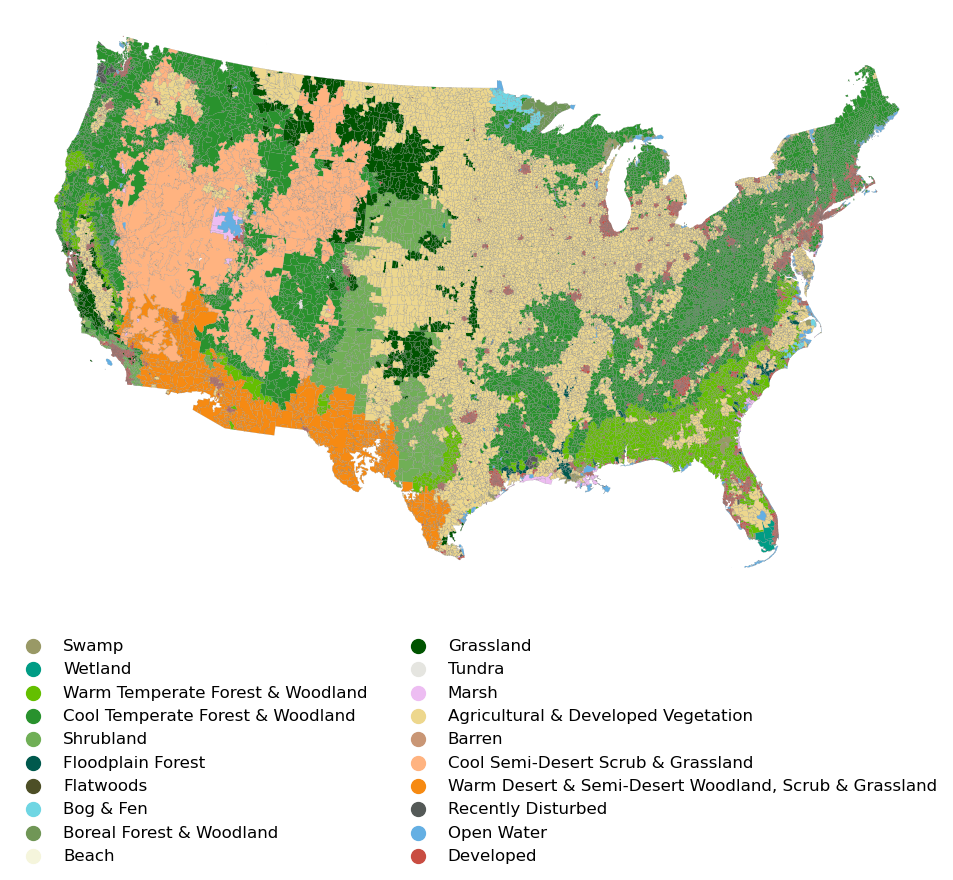

In [56]:
fig, ax = plt.subplots(1,1, figsize=(12, 10))

plot_landcover(
    gdf=gdf_plot,
    column='max_area',
    colors_dic=landcover_colors,
    ax=ax
)
#ax.title.set_text(f'Land Cover with Highest Percentage by Area on {landcover_detail} level')
ax.set_axis_off()

save_plot(path = f"{file_out_base_data_figures}_mainLandcover_area.pdf")


### Wilderness

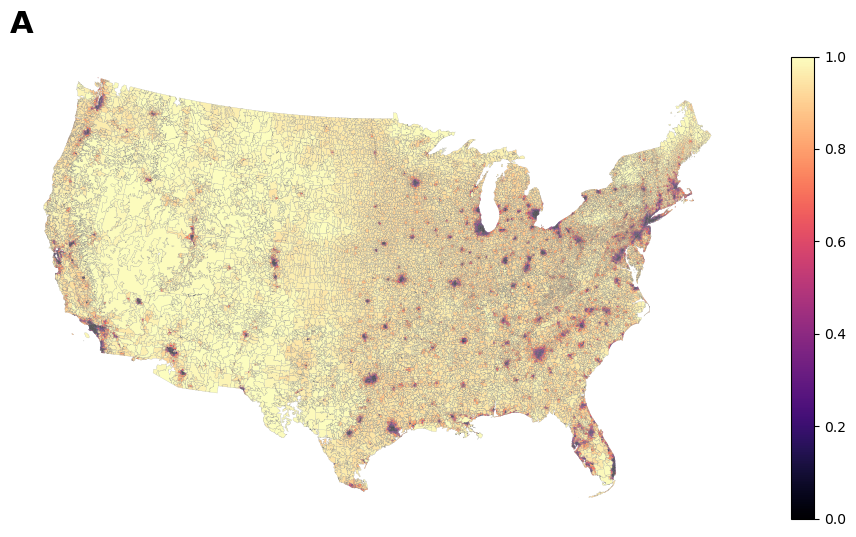

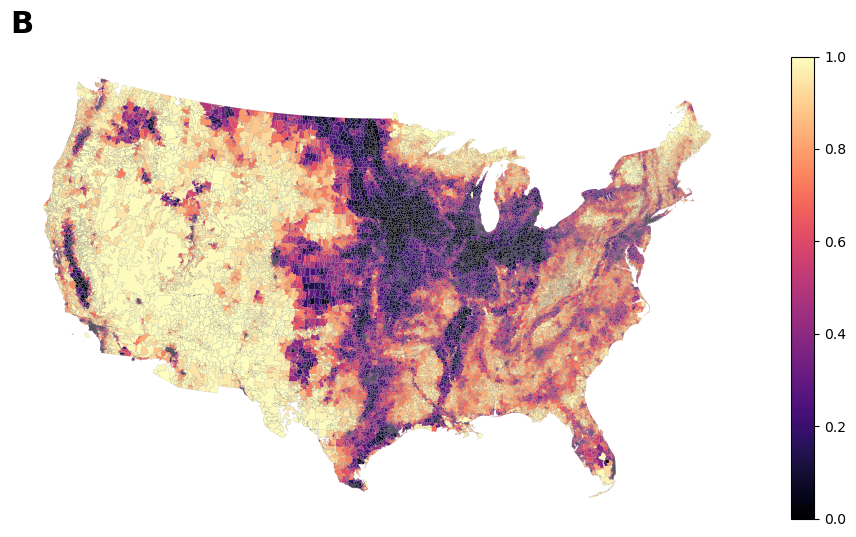

In [275]:
fig, ax1 = plt.subplots(1,1,figsize=(12,6))

gdf_plot.plot(
    column='WI_dev',
    ax=ax1,
    legend=True,
    cmap="magma",
    edgecolor="grey",
    linewidth = 0.1,
    rasterized=True
)
#ax1.set_title("Wilderness index (Percent of non-developed landcover)")
ax1.set_title('A', loc='left', weight='bold', fontsize=22)
ax1.set_axis_off()

save_plot(f"{file_out_base_data_figures}_wilderness_dev.pdf")


fig, ax2 = plt.subplots(1,1,figsize=(12,6))
gdf_plot.plot(
    column='WI_devagri',
    ax=ax2,
    legend=True,
    cmap="magma",
    edgecolor="grey",
    linewidth = map_params['linewidth'],
    rasterized=True
)
#ax2.set_title("Wilderness index (Percent of not human-used landcover)")
ax2.set_title('B', loc='left', weight='bold', fontsize=22)
ax2.set_axis_off()
save_plot(f"{file_out_base_data_figures}_wilderness_devagri.pdf")



In [30]:
from collections import Counter

print(Counter(df_combined[df_combined['WI_devagri'].isin(df_combined['WI_devagri'].nlargest(100))]['max_area']))

Counter(df_combined[(df_combined['WI_devagri']>0.9) & (df_combined['simpson']<0.5)]['max_area'])

Counter({'Cool Temperate Forest & Woodland': 55, 'Cool Semi-Desert Scrub & Grassland': 17, 'Open Water': 15, 'Warm Desert & Semi-Desert Woodland, Scrub & Grassland': 9, 'Shrubland': 1, 'Warm Temperate Forest & Woodland': 1, 'Marsh': 1, 'Grassland': 1})


Counter({'Cool Temperate Forest & Woodland': 1432,
         'Warm Desert & Semi-Desert Woodland, Scrub & Grassland': 212,
         'Cool Semi-Desert Scrub & Grassland': 166,
         'Shrubland': 99,
         'Warm Temperate Forest & Woodland': 63,
         'Open Water': 44,
         'Grassland': 37,
         'Marsh': 6,
         'Wetland': 2,
         'Floodplain Forest': 2,
         'Swamp': 1,
         'Bog & Fen': 1})

### Diversity

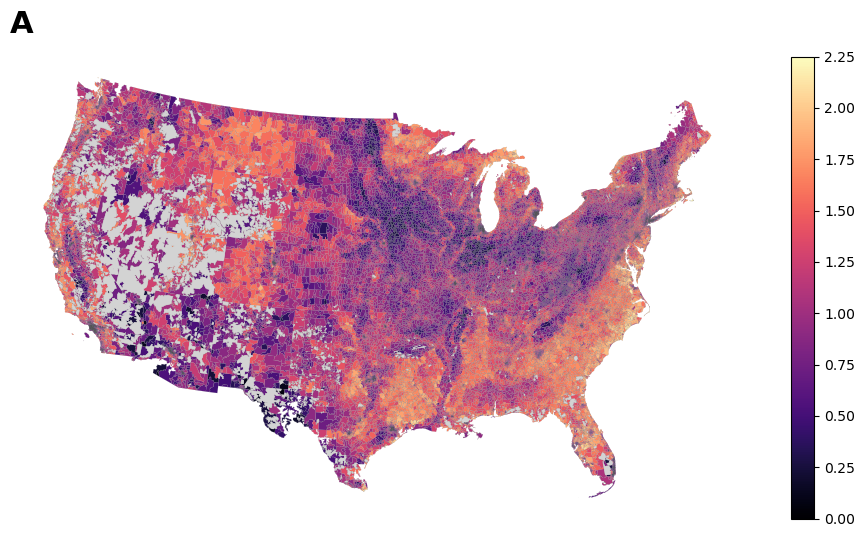

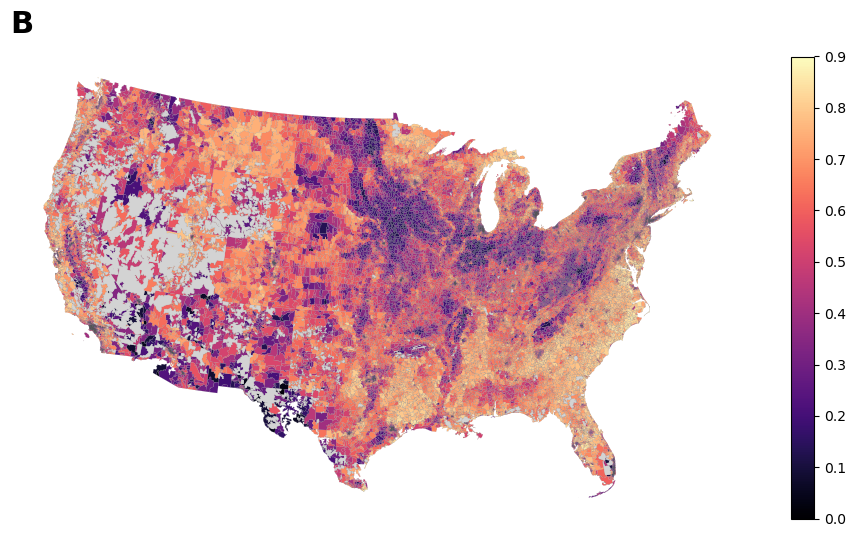

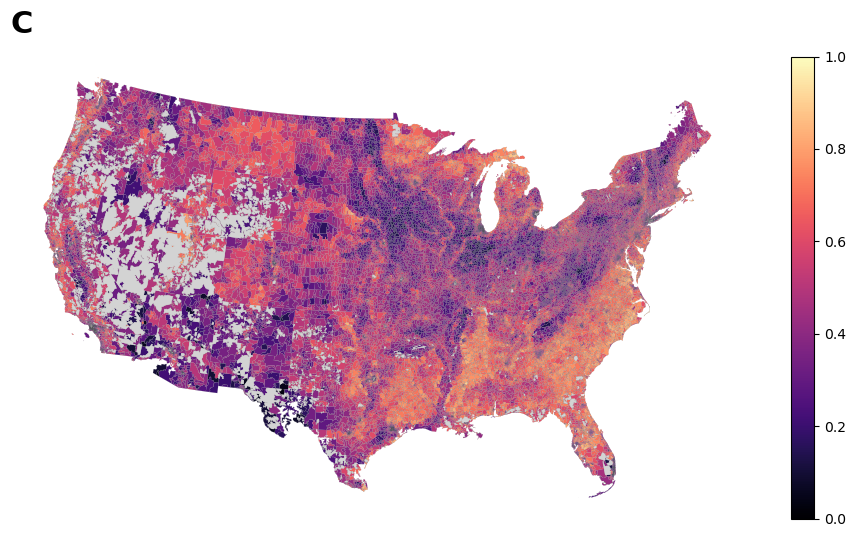

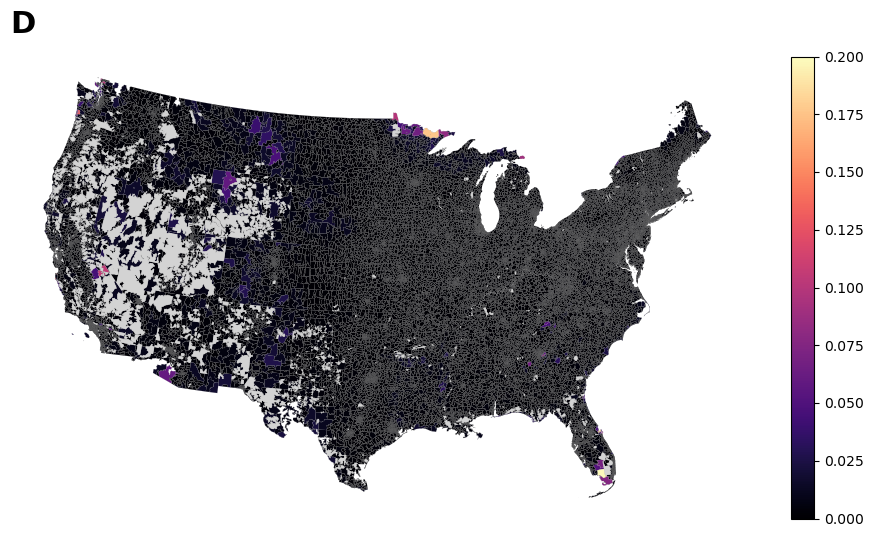

In [276]:
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(18,12))
missing_values_customization = dict(color = "lightgrey",)

fig, ax = plt.subplots(1,1, figsize=(12,6))
gdf_plot.plot(
    column = "shannon",
    ax=ax,
    legend=True,
    cmap="magma",
    edgecolor="grey",
    linewidth = map_params['linewidth'],
    rasterized=True,
    vmin = 0, 
    vmax = 2.25,
    missing_kwds = missing_values_customization
)
ax.set_axis_off()
ax.set_title("A", loc='left', weight='bold', fontsize=22)
save_plot(f"{file_out_base_data_figures}_stat_shannon.pdf")

fig, ax = plt.subplots(1,1, figsize=(12,6))
gdf_plot.plot(
    column = "simpson",
    ax=ax,
    legend=True,
    cmap="magma",
    edgecolor="grey",
    linewidth = map_params['linewidth'],
    rasterized=True,
    vmin = 0, 
    vmax = 0.9,
    missing_kwds = missing_values_customization
)
ax.set_axis_off()
ax.set_title("B", loc='left', weight='bold', fontsize=22)
save_plot(f"{file_out_base_data_figures}_stat_simpson.pdf")

fig, ax = plt.subplots(1,1, figsize=(12,6))
gdf_plot.plot(
    column = "pielou_evenness",
    ax=ax,
    legend=True,
    cmap="magma",
    edgecolor="grey",
    linewidth = map_params['linewidth'],
    rasterized=True,
    vmin = 0, 
    vmax = 1,
    missing_kwds = missing_values_customization
)
ax.set_axis_off()
ax.set_title("C", loc='left', weight='bold', fontsize=22)
save_plot(f"{file_out_base_data_figures}_stat_pielou_evenness.pdf")

fig, ax = plt.subplots(1,1, figsize=(12,6))
gdf_plot.plot(
    column = "richness_raretyWeighted",
    ax=ax,
    legend=True,
    cmap="magma",
    edgecolor="grey",
    linewidth = map_params['linewidth'],
    rasterized=True,
    vmin = 0, 
    vmax = 0.2,
    missing_kwds = missing_values_customization
)
ax.set_axis_off()
ax.set_title("D", loc='left', weight='bold', fontsize=22)
save_plot(f"{file_out_base_data_figures}_stat_richness_raretyWeighted.pdf")

# statistics = ['shannon', 'simpson', 'pielou_evenness', 'richness_raretyWeighted']
# for stat_index, stat in enumerate(statistics):
#     plot_statistics(stat=stat, title=ascii_uppercase[stat_index])


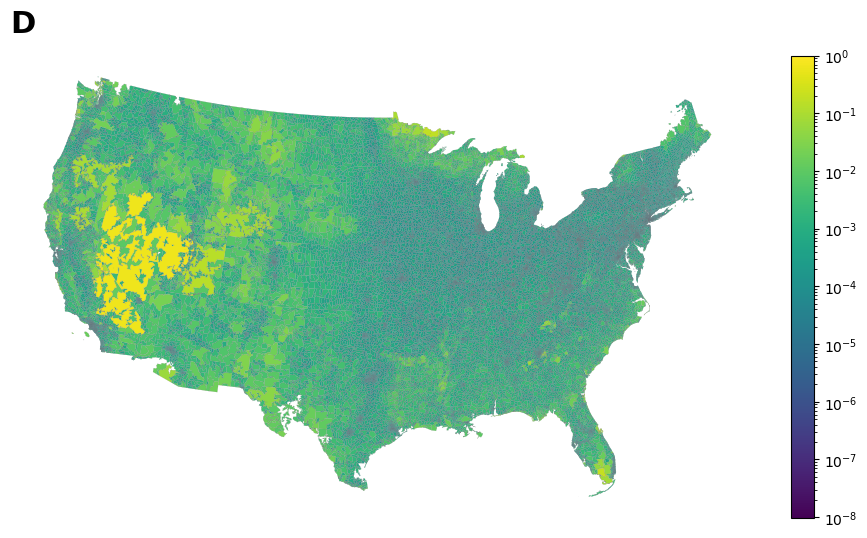

In [ ]:
%%script skipping

from matplotlib.colors import LogNorm
fig, ax = plt.subplots(1,1, figsize=(12,6))
gdf_plot.plot(
    column = "richness_raretyWeighted",
    ax=ax,
    legend=True,
    edgecolor="grey",
    linewidth = 0.1,
    rasterized=True,
    norm=LogNorm(vmin=gdf_plot['richness_raretyWeighted'].min(), vmax=1)
)
ax.set_axis_off()
ax.set_title("D", loc='left', weight='bold', fontsize=22)

save_plot(f"{file_out_base_data_figures}_stat_richness_raretyWeighted_log.pdf")

In [112]:
len(gdf_plot.nlargest(20, columns='area').loc[gdf_plot['ZIP_CODE'].str.startswith("NO_ZIP")])

14

In [113]:
len(gdf_plot.nlargest(20, columns='richness_raretyWeighted').loc[gdf_plot['ZIP_CODE'].str.startswith("NO_ZIP")])

4

In [98]:
gdf_plot['richness_raretyWeighted'].max()

0.1983345926975518

In [278]:
gdf_plot.nlargest(10, columns='richness_raretyWeighted')

ZIP_CODE                                           geometry  \
5795     34141  POLYGON ((1473436.016 423993.157, 1473557.120 ...   
4780     32780  POLYGON ((1471004.751 724525.580, 1471005.043 ...   
21542    55731  POLYGON ((264729.439 2790040.403, 264740.865 2...   
28250    93940  POLYGON ((-2274683.025 1816673.868, -2274644.3...   
23881    98586  POLYGON ((-2125797.713 2926143.533, -2125750.7...   
29360    93514  POLYGON ((-1979492.004 1833406.935, -1979288.1...   
21862    56711  POLYGON ((49864.604 2886177.422, 49866.437 288...   
23196    98226  POLYGON ((-1956956.376 3142299.621, -1956860.5...   
3283     30012  POLYGON ((1093518.444 1250188.501, 1093507.248...   
23598    98230  POLYGON ((-1962643.269 3160838.967, -1962624.2...   

       n_landcovers                            max_area    WI_dev  WI_devagri  \
5795             10                             Wetland  0.991584    0.991532   
4780             12                               Swamp  0.778237    0.772795   
21542            12            Boreal Forest & Woodland  0.996373    0.996174   
28250            13                           Developed  0.763688    0.744338   
23881            13    Cool Temperate Forest & Woodland  0.958082    0.955391   
29360            15  Cool Semi-Desert Scrub & Grassland  0.985976    0.959099   
21862            11                          Open Water  0.999491    0.998839   
23196            12    Cool Temperate Forest & Woodland  0.811866    0.630897   
3283             12                           Developed  0.712919    0.585708   
23598            11    Cool Temperate Forest & Woodland  0.782956    0.593293   

       n_tiles   shannon   simpson  pielou_evenness  richness_raretyWeighted  \
5795   2857079  1.063720  0.605619         0.461968                 0.198335   
4780    236681  1.821135  0.814194         0.732879                 0.180665   
21542  5407631  1.409076  0.700644         0.567054                 0.175943   
28250   132761  1.937453  0.837077         0.755357                 0.128525   
23881   539239  1.776488  0.785939         0.692601                 0.127087   
29360  2911788  1.498232  0.713405         0.553251                 0.104961   
21862  1714378  0.743361  0.358613         0.310005                 0.099414   
23196   328277  1.783500  0.770312         0.717733                 0.098725   
3283    125076  1.783328  0.803692         0.717664                 0.092259   
23598   135825  1.985967  0.831322         0.828213                 0.091949   

       clustering_zip  support_ratio_zip   ec_zip  label          area  \
5795         0.101259           0.987461      NaN    NaN  2.571379e+09   
4780         0.100460           0.976240  0.72168    3.0  2.130115e+08   
21542        0.130980           0.998240  1.24534    3.0  4.866864e+09   
28250        0.088950           0.884830  1.09783    3.0  1.194502e+08   
23881        0.134914           0.976956      NaN    NaN  4.853070e+08   
29360        0.125820           0.995130  0.80024    3.0  2.620593e+09   
21862             NaN                NaN      NaN    NaN  1.542949e+09   
23196        0.104130           0.945350  0.99232    3.0  2.954458e+08   
3283         0.093370           0.916720  0.60291    3.0  1.125484e+08   
23598        0.100830           0.934500  1.00566    3.0  1.222496e+08   

                                           cluster_color  
5795   (0.7843137254901961, 0.7843137254901961, 0.784...  
4780   (1.0, 0.8666666666666667, 0.8235294117647058, ...  
21542  (1.0, 0.8666666666666667, 0.8235294117647058, ...  
28250  (1.0, 0.8666666666666667, 0.8235294117647058, ...  
23881  (0.7843137254901961, 0.7843137254901961, 0.784...  
29360  (1.0, 0.8666666666666667, 0.8235294117647058, ...  
21862  (0.7843137254901961, 0.7843137254901961, 0.784...  
23196  (1.0, 0.8666666666666667, 0.8235294117647058, ...  
3283   (1.0, 0.8666666666666667, 0.8235294117647058, ...  
23598  (1.0, 0.8666666666666667, 0.8235294117647058, ...

In [123]:
df_combined.loc[df_combined["ZIP_CODE"] == "34141"]

ZIP_CODE max_area    WI_dev  WI_devagri    count  shannon   simpson  \
5795    34141  Wetland  0.991584    0.991532  2857079  1.06372  0.605619   

      pielou_evenness  richness_raretyWeighted  clustering_zip  \
5795         0.461968                 0.198335        0.101259   

      support_ratio_zip  ec_zip  
5795           0.987461     NaN

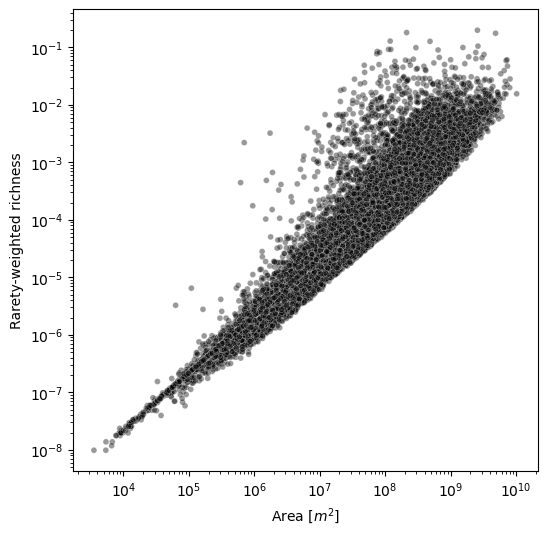

In [87]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
sns.scatterplot(
    x=gdf_plot.geometry.area,
    y=gdf_plot['richness_raretyWeighted'],
    color = "black",
    alpha = 0.4,
    size = 1,
    ax=ax
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel('Area [$m^{2}$]')
ax.set_ylabel("Rarety-weighted richness")
ax.get_legend().remove()

save_plot(f"{file_out_base_data_figures}_rwrVSarea.pdf")


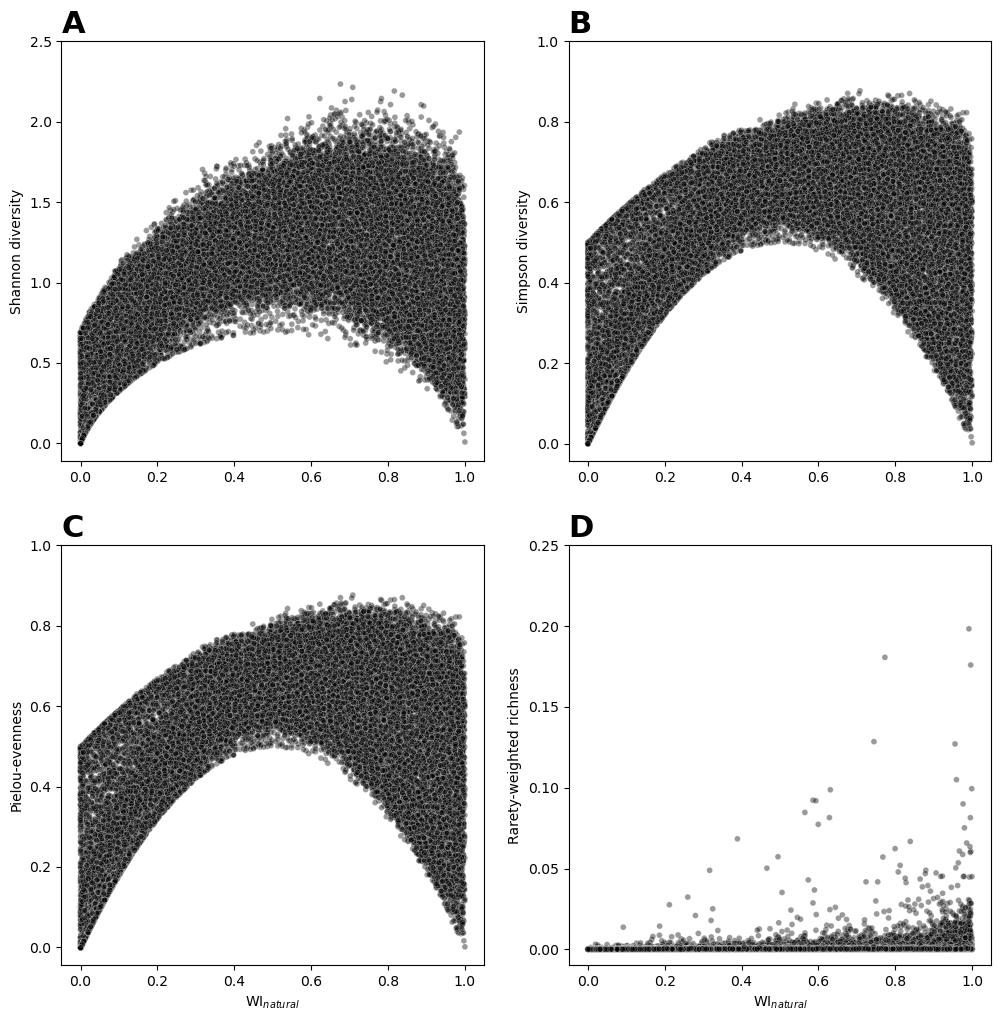

In [295]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12,12))

sns.scatterplot(
    data=df_combined,
    x="WI_devagri",
    y="shannon",
    color = "black",
    alpha = 0.4,
    size = 1,
    ax=ax1
)
ax1.set_ylabel("Shannon diversity")
ax1.set_xlabel("")
ax1.set_title('A', loc='left', weight='bold', fontsize=22)
ax1.set_yticks(np.arange(df_combined['shannon'].min(), df_combined['shannon'].max() + 0.5, 0.5))
ax1.get_legend().remove()

sns.scatterplot(
    data=df_combined,
    x="WI_devagri",
    y="simpson",
    color = "black",
    alpha = 0.4,
    size = 1,
    ax=ax2
)
ax2.set_ylabel("Simpson diversity")
ax2.set_xlabel("")
ax2.set_title('B', loc='left', weight='bold', fontsize=22)
ax2.set_yticks(np.arange(df_combined['simpson'].min(), df_combined['simpson'].max() + 0.2, 0.2))
ax2.get_legend().remove()

sns.scatterplot(
    data=df_combined,
    x="WI_devagri",
    y="simpson",
    color = "black",
    alpha = 0.4,
    size = 1,
    ax=ax3
)
ax3.set_ylabel("Pielou-evenness")
ax3.set_xlabel("WI$_{natural}$")
ax3.set_title('C', loc='left', weight='bold', fontsize=22)
ax3.set_yticks(np.arange(df_combined['pielou_evenness'].min(), df_combined['pielou_evenness'].max() + 0.2, 0.2))
ax3.get_legend().remove()

sns.scatterplot(
    data=df_combined,
    x="WI_devagri",
    y="richness_raretyWeighted",
    color = "black",
    alpha = 0.4,
    size = 1,
    ax=ax4
)
ax4.set_ylabel("Rarety-weighted richness")
ax4.set_xlabel("WI$_{natural}$")
ax4.set_title('D', loc='left', weight='bold', fontsize=22)
ax4.set_yticks(np.arange(df_combined['richness_raretyWeighted'].min(), round(df_combined['richness_raretyWeighted'].max(), 2)+0.1, 0.05))
ax4.get_legend().remove()

save_plot(f"{file_out_base_data_figures}_divVSwi.pdf")


<Axes: xlabel='WI_devagri', ylabel='Count'>

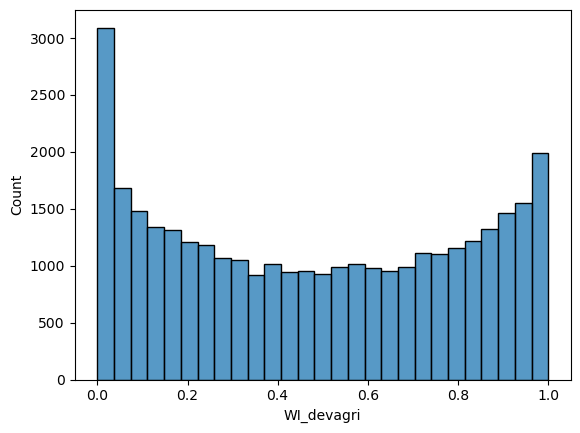

In [78]:
sns.histplot(
    df_combined['WI_devagri']
)

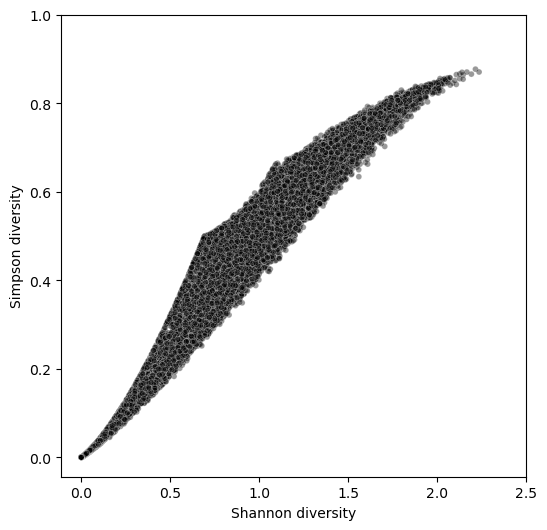

In [89]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
sns.scatterplot(
    data = df_combined,
    x = df_combined['shannon'],
    y = df_combined['simpson'],
    color = "black",
    alpha = 0.4,
    size = 1,
    ax = ax
)
ax.set_xlabel("Shannon diversity")
ax.set_ylabel("Simpson diversity")
ax.set_xticks(np.arange(df_combined['shannon'].min(), df_combined['shannon'].max() + 0.5, 0.5))
ax.set_yticks(np.arange(df_combined['simpson'].min(), df_combined['simpson'].max() + 0.2, 0.2))
ax.get_legend().remove()

plt.savefig(f"{file_out_base_data_figures}_simpsonVSshannon.pdf", format="pdf")

#### High rwr data looks interesting

In [ ]:
%%script echo skipping

cz_highRwr = gdf_diversity\
    .sort_values(by=['richness_raretyWeighted'], ascending=False)\
    .head(10)['fbcz_id']\
    .to_list()

gdf_shapes_landcover_areanorm\
    .loc[gdf_shapes_landcover_areanorm['fbcz_id'].isin(cz_highRwr)]\
    .to_csv(f"{os.path.splitext(file_areanorm)[0]}_highRwr.csv")
gdf_shapes_landcover_counts\
    .loc[gdf_shapes_landcover_counts['fbcz_id'].isin(cz_highRwr)]\
    .to_csv(f"{os.path.splitext(file_cellcounts)[0]}_highRwr.csv")
gdf_diversity\
    .loc[gdf_diversity['fbcz_id'].isin(cz_highRwr)]\
    .to_csv(f"{os.path.splitext(file_diversity)[0]}_highRwr.csv")

### Population vs diversity

In [ ]:
def polyname(poly):
    name = f"y = {round(poly[0],2)}"
    for i in range(1, len(poly)):
        if i == 1:
            if poly[i] >= 0:
                name = name + f" + {round(poly[i],2)}x"
            else:
                name = name + f" - {abs(round(poly[i],2))}x"
        else:
            if poly[i] >= 0:
                name = name + f" + {round(poly[i],2)}x^{{{i}}}"
            else:
                name = name + f" - {abs(round(poly[i],2))}x^{{{i}}}"

    return name

def plot_scatter(x, y, ax):
    ax.scatter(x,y)
    fit = np.polyfit(x, y, deg=1)
    xseq = np.linspace(min(x), max(x), num=100)
    ax.plot(xseq, fit[1] + fit[0] * xseq, color="k", lw=2.5)
    ax.text(max(x)*0.78, max(y)*1.075, polyname(fit), ha='center', va='center')
    ax.set_ylabel("Population")
    



In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(18,12))

plot_scatter(gdf_diversity['shannon'],gdf_diversity['win_popula'], ax1)
ax1.set_title("Shannon diversity", ha='right')

plot_scatter(gdf_diversity['simpson'],gdf_diversity['win_popula'], ax2)
ax2.set_title("Simpson diversity", ha='right')

plot_scatter(gdf_diversity['pielou_evenness'],gdf_diversity['win_popula'], ax3)
ax3.set_title("Pielou evenness", ha='right')

plot_scatter(gdf_diversity['richness_raretyWeighted'],gdf_diversity['win_popula'], ax4)
ax4.set_title("Rarety-weighted richness", ha='right')

plt.savefig(f"{file_out_base_data_figures}_statisticsVSpopulation.pdf", format="pdf")


In [ ]:
%%script echo skipping

# does richness show split lines?

fig, ax = plt.subplots(figsize=(9,6))
ax.scatter(gdf_diversity['richness_raretyWeighted'],gdf_diversity['win_popula'])
fit = np.polyfit(gdf_diversity['richness_raretyWeighted'], gdf_diversity['win_popula'], deg=1)
xseq = np.linspace(min(gdf_diversity['richness_raretyWeighted']), max(gdf_diversity['richness_raretyWeighted']), num=100)
ax.plot(xseq, fit[1] + fit[0] * xseq, color="k", lw=2.5)
ax.text(max(gdf_diversity['richness_raretyWeighted'])*0.78, max(gdf_diversity['win_popula'])*1.075, polyname(fit), ha='center', va='center')
ax.set_xscale('log')
ax.set_ylabel("Population")
ax.set_title("Rarety-weighted richness", ha='right')

plt.savefig(f"{file_out_base_data_figures}_statisticsVSpopulation_rwrLog.pdf", format="pdf")


In [ ]:
gdf_diversity["population_density"] = gdf_diversity['win_popula'] / gdf_diversity['area']

diversity_indices = ["shannon", "simpson", "pielou_evenness", "richness_raretyWeighted"]
for index in diversity_indices:
    gdf_diversity[f"{index}_densityweighted"] = gdf_diversity[index] * gdf_diversity['population_density']

In [ ]:
fig, ax = plt.subplots()
ax.hist(gdf_diversity["population_density"])
ax.set_yscale('log')

plt.savefig(f"{file_out_base_data_figures}_popdensity_hist.pdf", format="pdf")


In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(18,12))

gdf_diversity.plot(
    column = "shannon_densityweighted",
    ax=ax1,
    legend=True,
)
ax1.set_title("Shannon diversity, weighted by population density")

gdf_diversity.plot(
    column = "simpson_densityweighted",
    ax=ax2,
    legend=True
)
ax2.set_title("Simpson diversity, weighted by population density")

gdf_diversity.plot(
    column = "pielou_evenness_densityweighted",
    ax=ax3,
    legend=True
)
ax3.set_title("Pielou evenness, weighted by population density")

gdf_diversity.plot(
    column = "richness_raretyWeighted_densityweighted",
    ax=ax4,
    legend=True
)
ax4.set_title("Rarety-weighted richness, weighted by population density")

fig.tight_layout()

plt.savefig(f"{file_out_base_data_figures}_statistics_populationDensityWeighted.pdf", format="pdf")



### Social Capital

In [ ]:
def plot_socialCapital(df_socialCapital, stat):
    fig = plt.figure(figsize=(12, 12))

    ax1 = fig.add_subplot(2, 1, 1)
    df_socialCapital.plot(
        column=f'{stat}_median',
        legend=True,
        ax=ax1
    )
    ax1.axis("off")
    ax2 = fig.add_subplot(2, 2, 3)
    ax2.scatter(
        x=df_socialCapital[f'{stat}_median'],
        y=df_socialCapital[f'{stat}_min']
    )
    ax2.set_xlabel("Median")
    ax2.set_ylabel("Min")

    ax3 = fig.add_subplot(2, 2, 4)
    ax3.scatter(
        x=df_socialCapital[f'{stat}_median'],
        y=df_socialCapital[f'{stat}_max']
    )
    ax3.set_xlabel("Median")
    ax3.set_ylabel("Max")

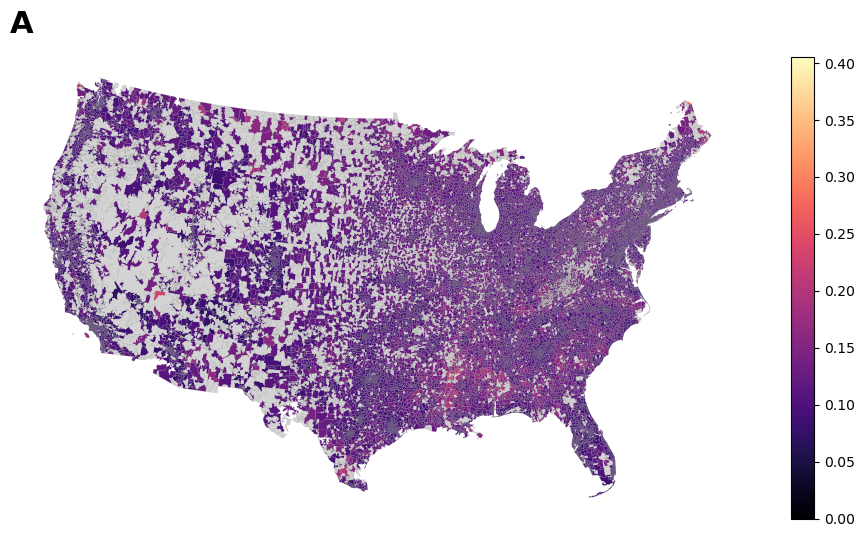

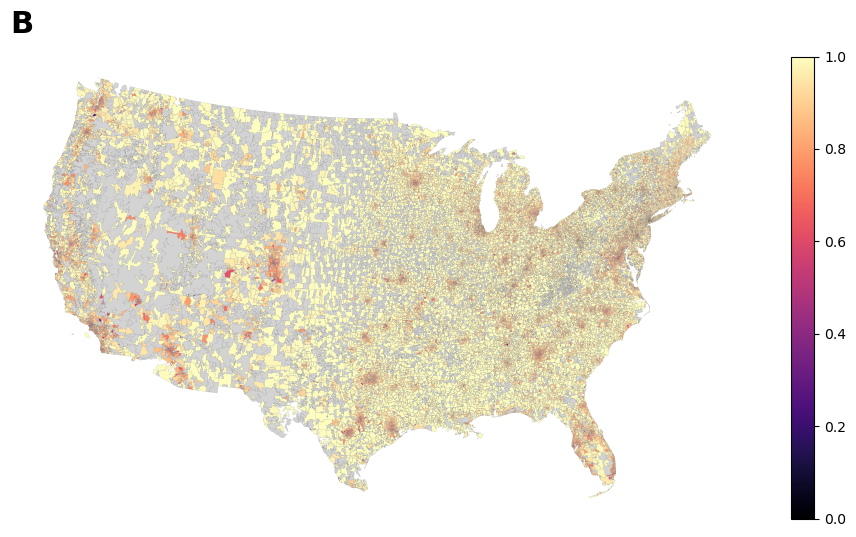

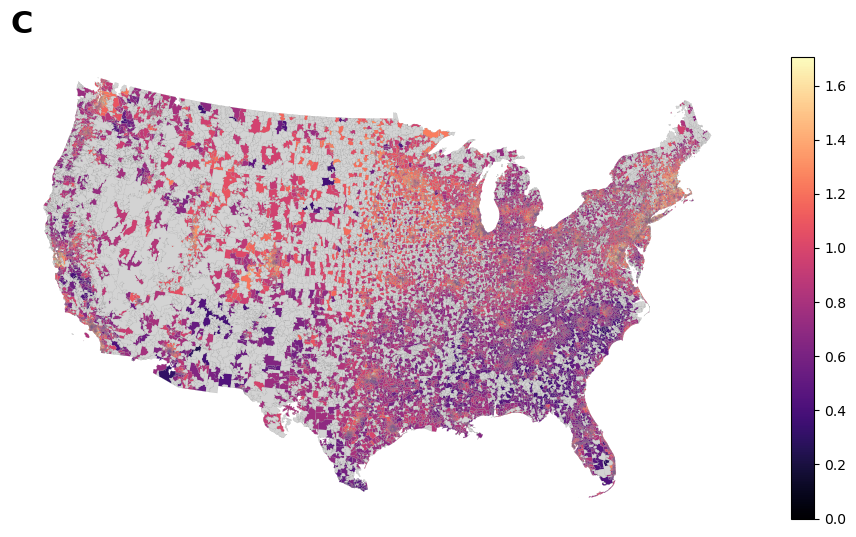

In [277]:
socialCapital_stats = ["clustering_zip", "support_ratio_zip", "ec_zip"]
for socstat_index, socstat in enumerate(socialCapital_stats):
    if level == "fbcz":
        plot_socialCapital(gdf_plot, socstat)
    elif level == "zip":
        fig, ax = plt.subplots(1,1, figsize=(12, 6))
        gdf_plot.plot(
            column=socstat,
            legend=True,
            ax=ax,
            cmap="magma",
            edgecolor="grey",
            linewidth = map_params['linewidth'],
            rasterized=True,
            vmin = 0,
            missing_kwds=missing_values_customization
        )
        ax.axis("off")
        ax.set_title(ascii_uppercase[socstat_index], loc='left', weight='bold', fontsize=22)
    save_plot(f"{file_out_base_data_figures}_socialCapital_{socstat}.pdf")


### Random Forest

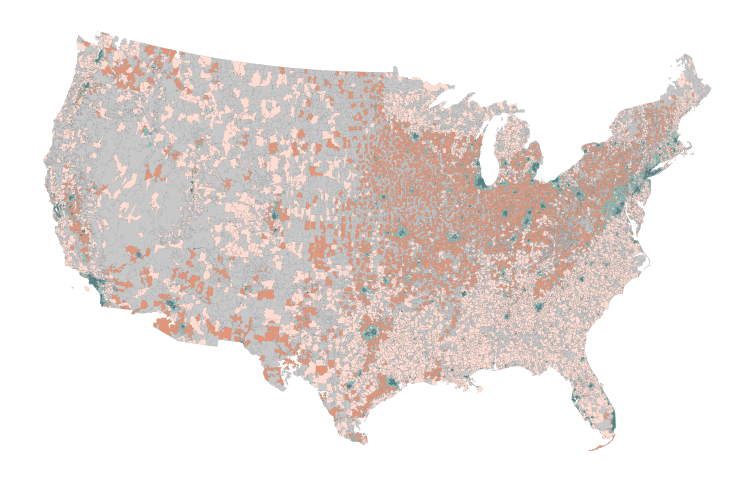

In [264]:
color_mapping = {1: '#e29578', 2: '#006d77', 3: '#ffddd2', 4: '#83c5be', np.NaN: "#C8C8C8"}
color_mapping = {k: to_rgba(v) for k, v in color_mapping.items()}

gdf_plot['cluster_color'] = gdf_plot['label'].map(color_mapping)

_, ax = plt.subplots(1,1, figsize=(12, 6))

gdf_plot.plot(
    color = gdf_plot["cluster_color"],
    categorical=True,
    edgecolor="grey",
    linewidth = map_params['linewidth'],
    rasterized=True,
    ax=ax
)
ax.axis("off")
save_plot(f"{file_out_base_data_figures}_randomforest_clusters.pdf")


### More

In [198]:
df_combined.fillna(0).astype(bool).sum(axis=0)

ZIP_CODE                   34014
n_landcovers               34014
max_area                   34014
WI_dev                     33278
WI_devagri                 33132
n_tiles                    34014
shannon                    32563
simpson                    32563
pielou_evenness            32563
richness_raretyWeighted    33297
clustering_zip             22892
support_ratio_zip          22891
ec_zip                     18862
dtype: int64

In [172]:
maxcover_counts = df_combined['max_area'].value_counts()
maxcover_counts = pd.DataFrame(maxcover_counts)\
    .reset_index()\
    .rename(columns={"max_area": "Landcover_categories", "count": "Count_max_area"})
maxcover_counts_sum = maxcover_counts['Count_max_area'].sum()
maxcover_counts['Perc_max_area'] = maxcover_counts['Count_max_area'] / maxcover_counts_sum * 100
maxcover_counts['Perc_max_area'] = maxcover_counts['Perc_max_area'].round(2).astype(object)
maxcover_counts.loc[\
    (maxcover_counts['Perc_max_area'].astype(float) == 0) & \
    (maxcover_counts['Count_max_area'] != 0), 'Perc_max_area'\
    ] = "<0.01"

total_landcover = df_shapes_landcover_counts.drop(columns=['ZIP_CODE', 'count']).sum(axis=0, skipna=True)
total_landcover = pd.DataFrame(total_landcover)\
    .reset_index()\
    .rename(columns={"index": "Landcover_categories", 0: "Count_cover_tiles"})
total_landcover_sum = total_landcover['Count_cover_tiles'].sum()
total_landcover['Percentage_cover_tiles'] = total_landcover['Count_cover_tiles'] / total_landcover_sum * 100
total_landcover['Percentage_cover_tiles'] = total_landcover['Percentage_cover_tiles'].round(2).astype(object)
total_landcover.loc[\
    (total_landcover['Percentage_cover_tiles'].astype(float) == 0) & \
    (total_landcover['Count_cover_tiles'] != 0), 'Percentage_cover_tiles'\
    ] = "<0.01"

landcover_stats = total_landcover\
    .merge(maxcover_counts, on="Landcover_categories", how="outer")\
    .fillna(0)

landcover_stats.to_csv(f"{file_out_base_data_detail}_landcover_summary.csv", index=False)

In [34]:
coverage_zips = pd.melt(
    df_shapes_landcover_areanorm, 
    id_vars='ZIP_CODE', 
    value_vars=df_shapes_landcover_areanorm.columns.to_list().remove('ZIP_CODE')
)\
    .rename(columns={"variable": "landcover", "value": "percent_cover"})

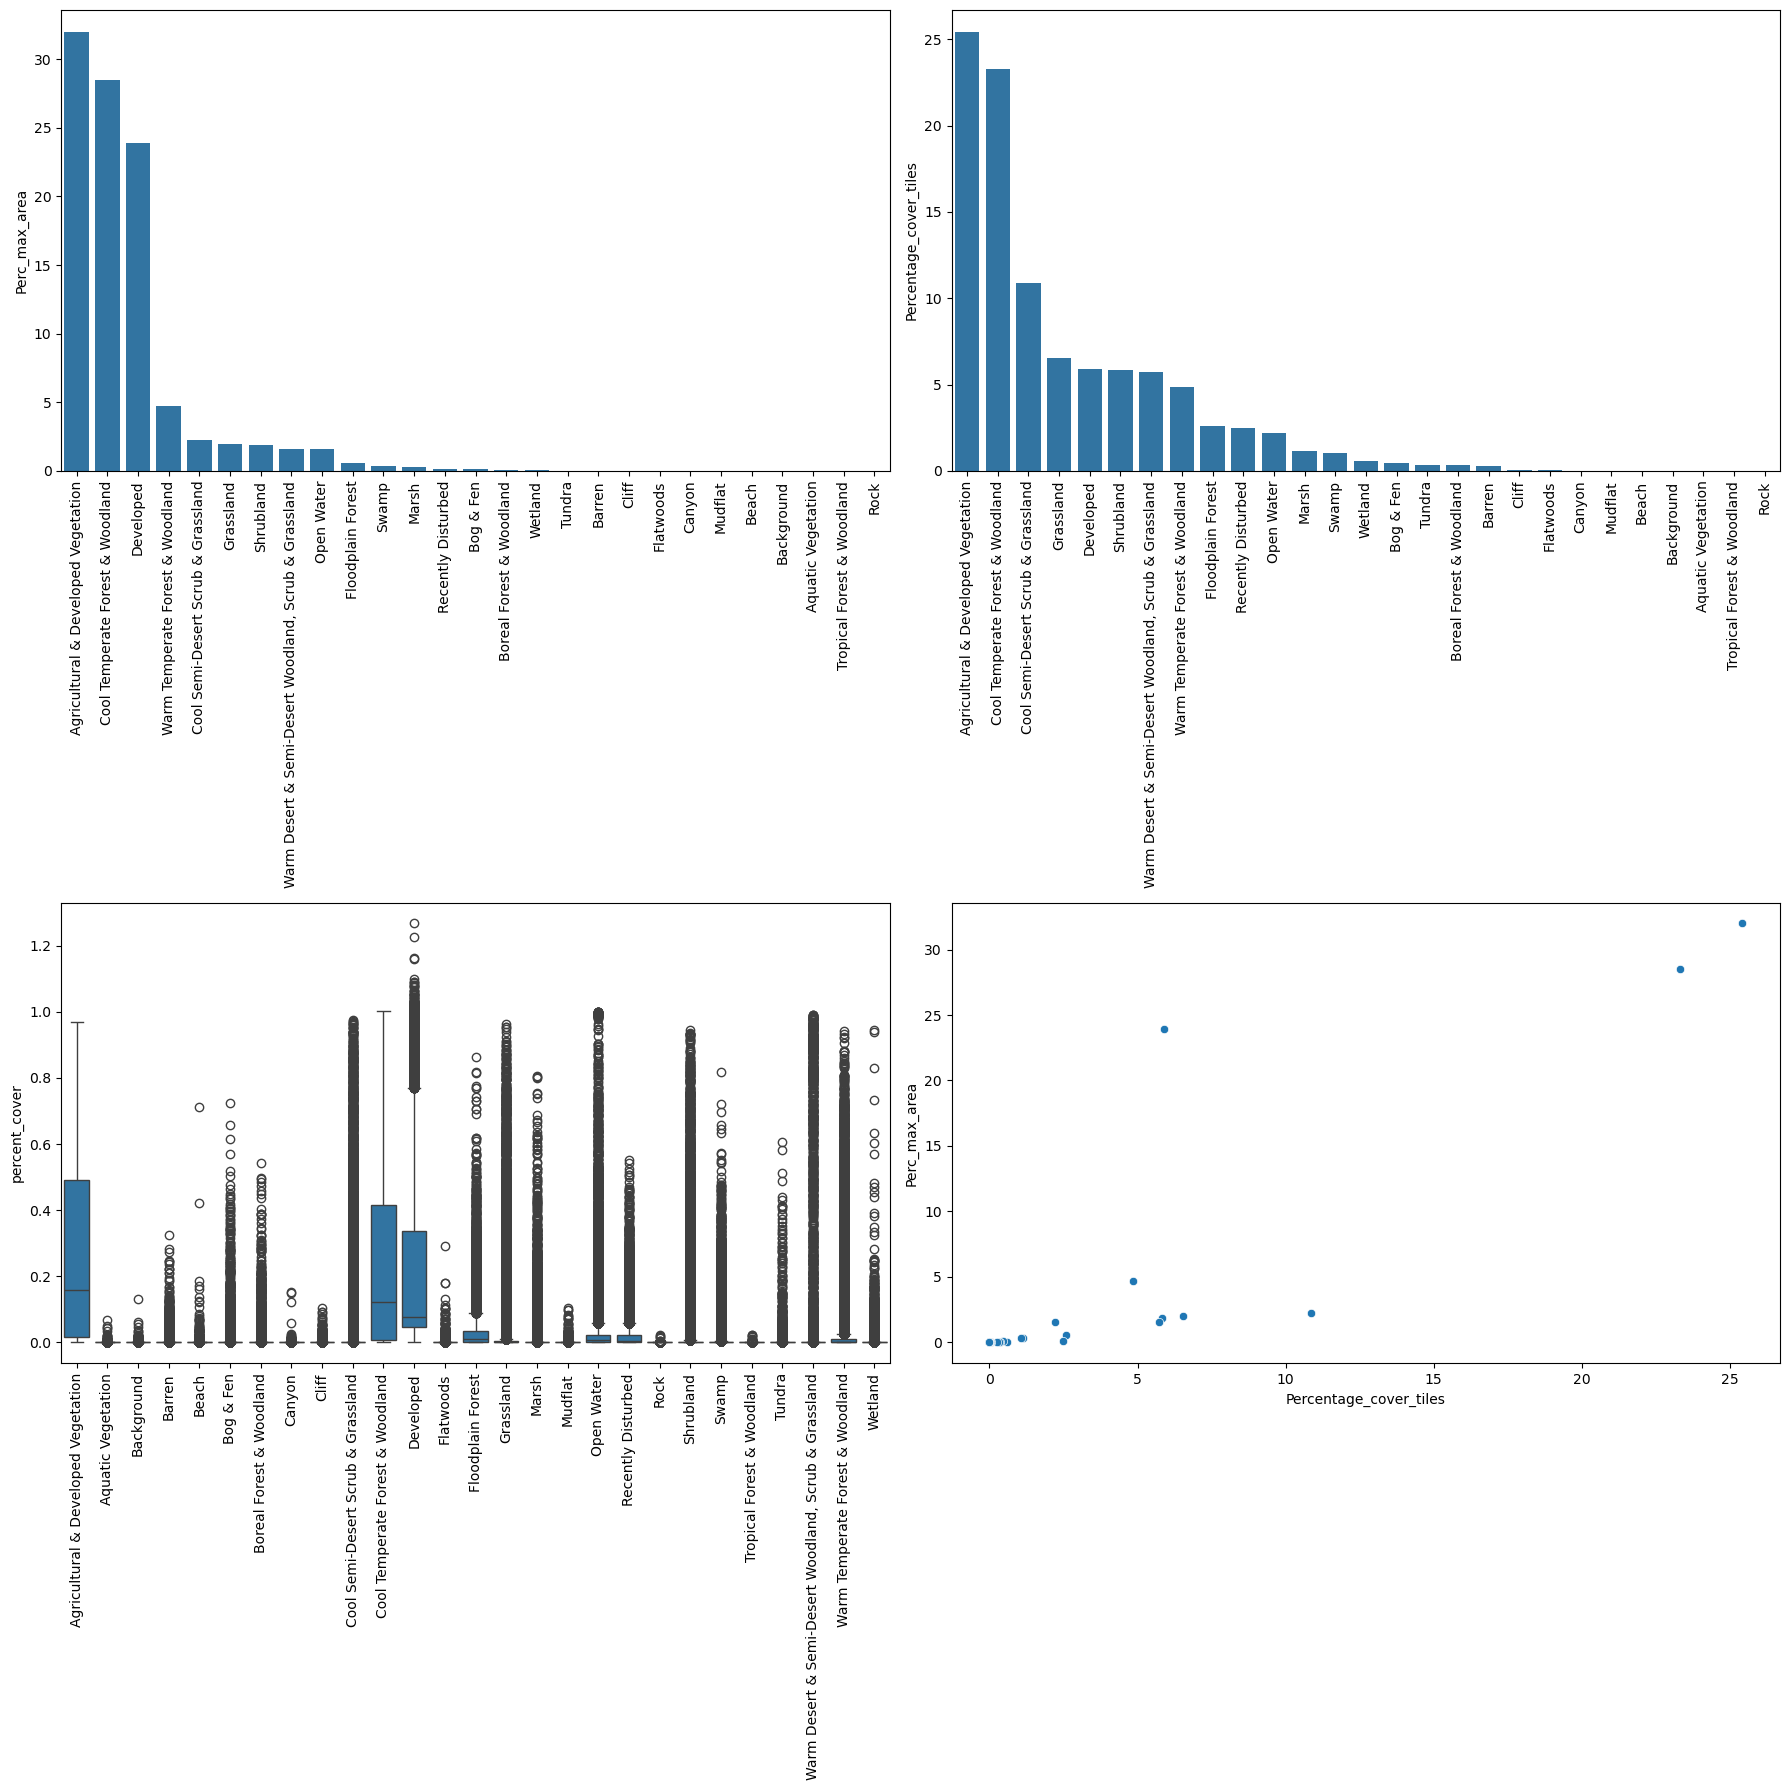

In [65]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(18,18))


sns.barplot(
    data=landcover_stats.sort_values(by='Perc_max_area', ascending=False),
    x='Landcover_categories',
    y='Perc_max_area',
    ax=ax1
)
ax1.tick_params(axis='x', rotation=90)
ax1.set_xlabel("")

sns.barplot(
    data= landcover_stats.sort_values(by='Percentage_cover_tiles', ascending=False),
    x = 'Landcover_categories',
    y = 'Percentage_cover_tiles',
    ax=ax2
)
ax2.tick_params(axis='x', rotation=90)
ax2.set_xlabel("")

sns.boxplot(
    x = coverage_zips['landcover'],
    y = coverage_zips['percent_cover'],
    ax=ax3
)
ax3.tick_params(axis='x', rotation=90)
ax3.set_xlabel("")
ax3.set_title("")

sns.scatterplot(
    x=landcover_stats['Percentage_cover_tiles'],
    y=landcover_stats['Perc_max_area']
)

fig.tight_layout()
plt.savefig(f"{file_out_base_data_figures}_coverage_overview.pdf", format="pdf")


In [126]:
print(f"Total number of ZIPs: {maxcover_counts['Count_max_area'].sum():,}")

urban_counts = maxcover_counts.loc[maxcover_counts['Landcover_categories'] == 'Developed', 'Count_max_area'].iat[0]
print(f"ZIPs for which 'Developed' is the highest landcover: {urban_counts:,}")

urban_percent = urban_counts / maxcover_counts['Count_max_area'].sum()
print(f"In percent of all ZIPs: {round(urban_percent * 100, 2)}")

urban_area = gdf_plot.loc[gdf_plot['max_area'] == 'Developed']['area'].sum() / gdf_plot['area'].sum()
print(f"Area covered by those ZIPs in percent: {round(urban_area * 100, 2)}")

Total number of ZIPs: 34,014
ZIPs for which 'Developed' is the highest landcover: 8,129
In percent of all ZIPs: 23.9
Area covered by those ZIPs in percent: 2.43


In [175]:
print(f"Number of categories as max cover: {len(maxcover_counts['Landcover_categories'])}")
print(f"In regular ZCTAs (no NO_ZIP): {df_combined.loc[df_combined['ZIP_CODE'].str.startswith('NO_ZIP')]}")

Number of categories as max cover: 20


In [193]:
df_combined.loc[(~df_combined['ZIP_CODE'].str.startswith('NO_ZIP')) & (~df_combined['clustering_zip'].isna())]['max_area'].unique()

array(['Agricultural & Developed Vegetation',
       'Cool Temperate Forest & Woodland', 'Developed', 'Open Water',
       'Swamp', 'Cool Semi-Desert Scrub & Grassland', 'Floodplain Forest',
       'Marsh', 'Shrubland', 'Grassland', 'Wetland',
       'Warm Temperate Forest & Woodland', 'Recently Disturbed',
       'Bog & Fen',
       'Warm Desert & Semi-Desert Woodland, Scrub & Grassland', 'Tundra',
       'Boreal Forest & Woodland'], dtype=object)

In [194]:
from collections import Counter

Counter(df_combined.loc[(~df_combined['ZIP_CODE'].str.startswith('NO_ZIP')) & (~df_combined['clustering_zip'].isna())]['max_area'])

Counter({'Agricultural & Developed Vegetation': 7158,
         'Developed': 6539,
         'Cool Temperate Forest & Woodland': 6266,
         'Warm Temperate Forest & Woodland': 1207,
         'Cool Semi-Desert Scrub & Grassland': 302,
         'Shrubland': 289,
         'Open Water': 279,
         'Warm Desert & Semi-Desert Woodland, Scrub & Grassland': 273,
         'Grassland': 261,
         'Floodplain Forest': 99,
         'Swamp': 77,
         'Marsh': 70,
         'Bog & Fen': 26,
         'Recently Disturbed': 24,
         'Boreal Forest & Woodland': 10,
         'Wetland': 9,
         'Tundra': 3})

In [279]:
df_combined.loc[df_combined['max_area'] == 'Tundra']

ZIP_CODE  n_landcovers max_area    WI_dev  WI_devagri  n_tiles  \
17341    81427            12   Tundra  0.978376    0.977642   215180   
17360    80420            11   Tundra  0.986004    0.986004   121817   
17793    80444            13   Tundra  0.983071    0.982945   110935   
17816    81433            12   Tundra  0.992118    0.991947   645482   
18306    80476            12   Tundra  0.971559    0.971559   168175   
18573    81426            11   Tundra  0.996376    0.994742    28145   

        shannon   simpson  pielou_evenness  richness_raretyWeighted  \
17341  1.356575  0.651807         0.545926                 0.005236   
17360  1.175643  0.575389         0.490281                 0.002799   
17793  1.153033  0.603117         0.449535                 0.002003   
17816  1.188066  0.582802         0.478113                 0.017550   
18306  1.128549  0.593929         0.454162                 0.003032   
18573  1.332309  0.660077         0.555616                 0.000600   

       clustering_zip  support_ratio_zip   ec_zip  
17341        0.083820           0.979560  1.16734  
17360             NaN                NaN      NaN  
17793        0.096165           0.972907      NaN  
17816        0.082063           0.987647      NaN  
18306             NaN                NaN      NaN  
18573             NaN                NaN      NaN